## Homework Natural Language Processing

In deze notebook ga je een **sentiment analyse** doen op de reviews die bezoekers op Trip Advisor achterlieten na het bezoeken van 1 van de pretparken van Disney. Ga experimenteel na hoe je een goed voorspellend model kan bouwen om het sentiment van een review te voorspellen, puur aan de hand van de woorden (features) in de review. 

Je bouwt deze notebook __stap per stap op__. Voorzie volgende onderdelen in je notebook :

- Stap 1 : data inlezen en voorbereiden
- Stap 2 : NLP pipeline *(zie ook theorie)*
- Stap 3 : Model opstellen: Experimenteer met volgende 3 methodes
    * Gebruik de NLTK library & Vader 
    * Gebruik een Bag-of-Words approach in combinatie met een klassiek ML algoritme
    * Gebruik een RNN model
- Stap 4 : Conclusie

Voorzie tevens in elke stap een __woordje uitleg over de keuzes__ die je maakt en de __resultaten__ die je hiermee bekomt. 
</br>Geef ook een vergelijking tussen de 3 methodes.

<img src="img/disneyland.jpeg" alt="Disneyland"
	title="Disneyland" width="800" height="400" />

De **verbetersleutel** ziet er als volgt uit:


|  Stap    | #punten | 
|-----------|:--------:|
|  Stap 1: |     /1   |  
|  Stap 2: |     /4   |  
|  Stap 3: |        |  
|  ---> 3.1 |     /2    |  
|  ---> 3.2 |      /4| 
|  ---> 3.3 |      /4   |  
| Stap 4:|     /2    |
| Rapportering :|     /3   |  
|      Totaal: |     /20    | 


### Praktische afspraken:
Dit project wordt ingediend door deze notebook verder thuis af te werken en te uploaden op Toledo voor de start van je labo in **de week van maandag 10 januari 2022**

#### Alvast veel succes!

### Stap 1 : data inladen

De data bestaat uit een .csv file die rechtstreeks ingeladen kan worden. De belangrijkste kolommen zijn uiteraard de _Review_text_ en de _Rating_ kolom. De ratings gaan van een waarde 1 tot 5, waarbij 5 uitstekend is (heel positieve review) en 1 een slechte review. </br>Modeleer hieruit een classificatieprobleem (je hoeft zeker geen 5 klassen te behouden, herwerk bvb naar een binaire classificatie of eventueel naar een probleem met 3 klassen (positief neutraal, negatief).

Ga na of er waarden ontbreken, zo ja verwijder deze data.
Ga na hoeveel data je per categorie hebt. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS    

nltk.download(['stopwords', 'vader_lexicon', 'punkt'])

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/louisdhont/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/louisdhont/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/louisdhont/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("../data/DisneylandReviews.csv",encoding='latin-1')
original_df = df
df.sample(5)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
1645,541358288,4,2017-11,Australia,Take an umbrella and you'll be ok. Lines are u...,Disneyland_HongKong
20893,231116200,4,2014-9,United States,"I come to Disney about once a year, so I'm not...",Disneyland_California
17153,323325301,5,2015-10,United States,"Who doesn't love Disneyland !! Spent a coup,e...",Disneyland_California
29866,613346388,4,2018-9,United Kingdom,I ve visited Disneyland several times over t...,Disneyland_Paris
3026,443636227,1,2016-12,South Africa,Do NOT take your toddler to Disneyworld. The l...,Disneyland_HongKong


In [3]:
## to remove the duplicates data
df.drop_duplicates(subset='Review_ID', inplace=True, keep='first')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42636 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42636 non-null  int64 
 1   Rating             42636 non-null  int64 
 2   Year_Month         42636 non-null  object
 3   Reviewer_Location  42636 non-null  object
 4   Review_Text        42636 non-null  object
 5   Branch             42636 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.3+ MB


In [5]:
df=df.dropna().reset_index()
print ("Missing values: ", df.isnull().sum().values.sum())
df.head()

Missing values:  0


,index,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [6]:
df.drop(columns=['index', 'Review_ID', 'Year_Month', 'Reviewer_Location'], inplace=True)

In [7]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values: ", df.isnull().sum().values.sum())
print ("Unique values:\n",df.nunique())

Rows     :  42636
Columns  :  3

Features : 
 ['Rating', 'Review_Text', 'Branch']

Missing values:  0
Unique values:
 Rating             5
Review_Text    42624
Branch             3
dtype: int64


In [8]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42636 entries, 0 to 42635
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rating       42636 non-null  int64 
 1   Review_Text  42636 non-null  object
 2   Branch       42636 non-null  object
dtypes: int64(1), object(2)
memory usage: 999.4+ KB


In [9]:
df['Review_Text'].values[2:3]

array(['Thanks God it wasn   t too hot or too humid when I was visiting the park   otherwise it would be a big issue (there is not a lot of shade).I have arrived around 10:30am and left at 6pm. Unfortunately I didn   t last until evening parade, but 8.5 hours was too much for me.There is plenty to do and everyone will find something interesting for themselves to enjoy.It wasn   t extremely busy and the longest time I had to queue for certain attractions was 45 minutes (which is really not that bad).Although I had an amazing time, I felt a bit underwhelmed with choice of rides and attractions. The park itself is quite small (I was really expecting something grand   even the main castle which was closed by the way was quite small).The food options are good, few coffee shops (including Starbucks) and plenty of gift shops. There was no issue with toilets as they are everywhere.All together it was a great day out and I really enjoyed it.'],
      dtype=object)

In [10]:
df.head()

,Rating,Review_Text,Branch
0,4,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,4,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,4,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,4,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4,"the location is not in the city, took around 1...",Disneyland_HongKong


In [11]:
rating_count = df.Rating.value_counts()
rating_count

5    23137
4    10768
3     5105
2     2127
1     1499
Name: Rating, dtype: int64

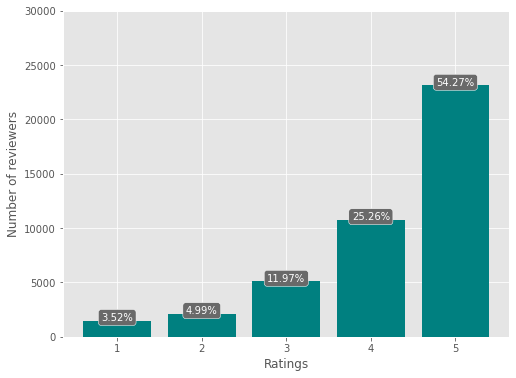

In [12]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(8, 6))
    plt.bar(rating_count.index, rating_count.values, color='teal')
    for r, val in zip(rating_count.index, rating_count.values):
        plt.text(r, val, 
                 str(round(val/sum(rating_count.values)*100, 2))+'%', 
                 ha='center', color='white', 
                 bbox=dict(facecolor='dimgrey', edgecolor='white', boxstyle="round"))
    plt.xlabel('Ratings')
    plt.ylabel('Number of reviewers')
    plt.yticks(np.arange(0, 30001, 5000))

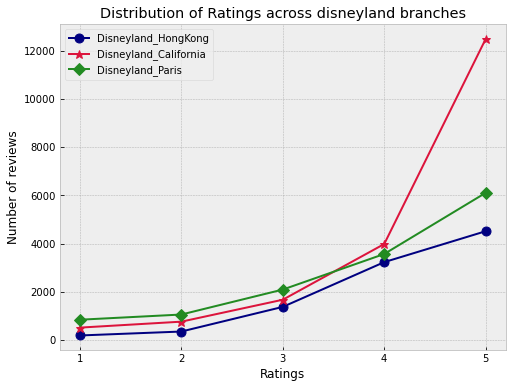

In [13]:
markers = ['o', '*', 'D']
branch_col = ['navy', 'crimson', 'forestgreen']
with plt.style.context('bmh'):
    plt.figure(figsize=(8, 6))
    for branch, m, col in zip(df.Branch.unique(), markers, branch_col):
        counts = df[df.Branch == branch]['Rating'].value_counts()
        x = counts.index
        y = counts.values
        plt.plot(x, y, marker=m, markersize=9, color=col, label=branch)
        plt.xticks(np.arange(1, 6))
        plt.xlabel('Ratings')
        plt.ylabel('Number of reviews')
    plt.title('Distribution of Ratings across disneyland branches')
    plt.legend()
    plt.show()

In [14]:
df.head()

,Rating,Review_Text,Branch
0,4,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,4,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,4,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,4,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4,"the location is not in the city, took around 1...",Disneyland_HongKong


In [15]:
### Generate word clouds
stopwords = set(STOPWORDS)
stopwords.update(["park", "parks", "ride", "rides", "Disney", "Disneyland"])

(-0.5, 1599.5, 799.5, -0.5)

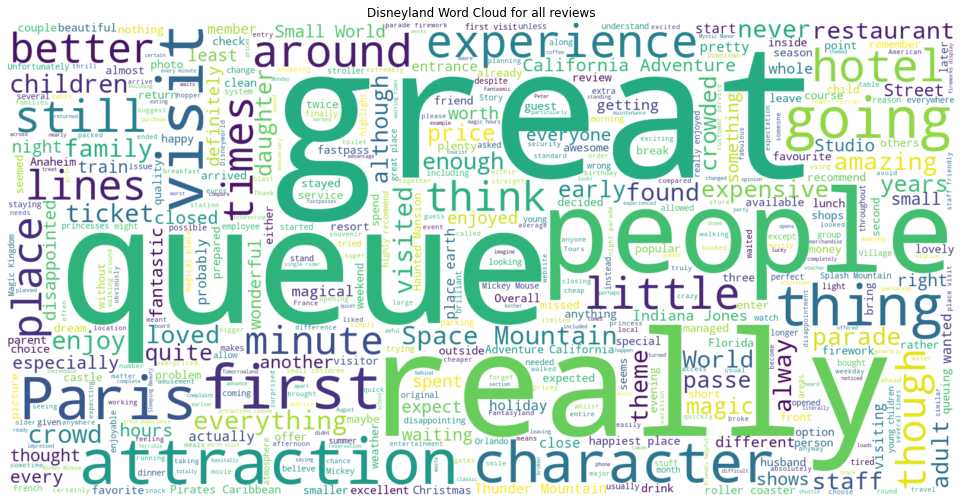

In [16]:
### Disneyland Parks overall word cloud

text = " ".join(review for review in df.Review_Text)

plt.figure(figsize=(17, 17))
wc = WordCloud(stopwords=stopwords, max_words=500, width=1600, height=800, min_word_length=5, background_color='white').generate(text)
plt.title("Disneyland Word Cloud for all reviews")
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

In [17]:
### Separate Disneyland dataframes into there scores
score_1 = df.loc[df['Rating'] == 1]
score_2 = df.loc[df['Rating'] == 2]
score_3 = df.loc[df['Rating'] == 3]
score_4 = df.loc[df['Rating'] == 4]
score_5 = df.loc[df['Rating'] == 5]

(-0.5, 399.5, 199.5, -0.5)

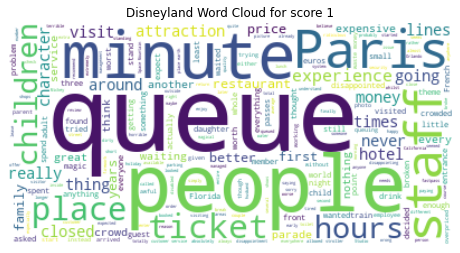

In [18]:
text1 = " ".join(review for review in score_1.Review_Text)

plt.figure(figsize=(8, 10))
wc = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text1)
plt.title("Disneyland Word Cloud for score 1")
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

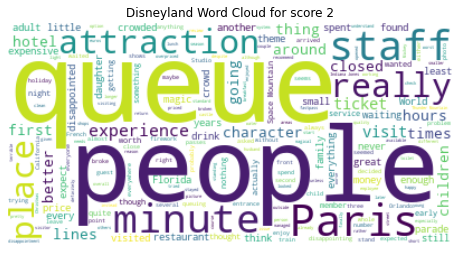

In [19]:
text2 = " ".join(review for review in score_2.Review_Text)

plt.figure(figsize=(8, 10))
wc2 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text2)
plt.title("Disneyland Word Cloud for score 2")
plt.imshow(wc2, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

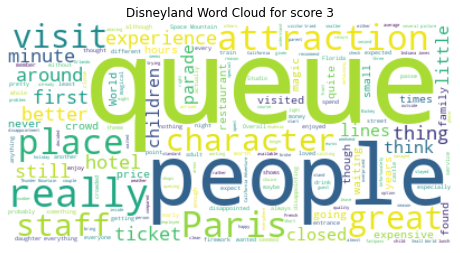

In [20]:
text3 = " ".join(review for review in score_3.Review_Text)

plt.figure(figsize=(8, 10))
wc3 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text3)
plt.title("Disneyland Word Cloud for score 3")
plt.imshow(wc3, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

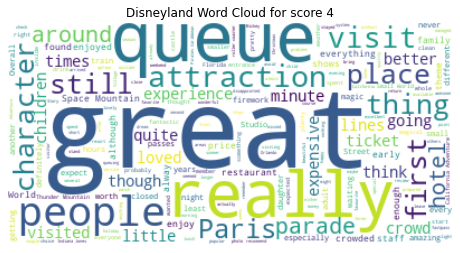

In [21]:
text4 = " ".join(review for review in score_4.Review_Text)

plt.figure(figsize=(8, 10))
wc4 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text4)
plt.title("Disneyland Word Cloud for score 4")
plt.imshow(wc4, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

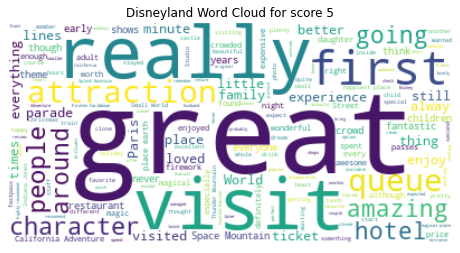

In [22]:
text5 = " ".join(review for review in score_5.Review_Text)

plt.figure(figsize=(8, 10))
wc5 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text5)
plt.title("Disneyland Word Cloud for score 5")
plt.imshow(wc5, interpolation='bilinear')
plt.axis('off')

### Stap 2 : Text Processing Pipeline

Voorzie volgende stappen. Je kan hiervoor gebruik maken van de __NLTK library in Python__ (zie bv. https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk).

De keuze voor vectorizatie kies je in de volgende stap, die keuze is immers afhankelijk van hoe je de uitwerking gaat doen).
Uiteindelijk moet elke review vertaald worden naar een zin waarin volgende aanpassingen gebeuren :

1. **Tokenization**: split elke review in woorden, zodat je er de volgende stappen kan op loslaten

2. **Punctuation removal** : 
      je kan volgende punctuations verwijderen uit de review : "!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
      
3. **Stopword Removal**: 
    de nltk.corpus module voorziet een lijst van stopwoorden die je kan gebruiken om te verwijderen uit de reviews:
          
        import nltk
        from nltk.corpus import stopwords
        
    Deze moet je vooraf wel downloaden bvb via cmd line : _python -m nltk.downloader stopwords_
        
4. **Lower casing / negation handling**

5. **Lemmatizing / Stemming** : Kies in deze stap voor Lemmatizing of Stemming. Voer beiden eens uit, kijk naar de verschillen en maak een keuze.
    Zowel Lemmatizing als Stemming kan je via de NLTK library uitvoeren. zie bvb. https://www.geeksforgeeks.org/python-lemmatization-with-nltk/ en https://www.geeksforgeeks.org/python-stemming-words-with-nltk/.
    Als je wordnet wil gebruiken zal je deze ook eerst moeten downloaden: 
   
    python -m nltk downloader wordnet



In [23]:
df['Original_Text'] = df['Review_Text']

### Tokenizen, Lower casing & Punctuation removal

In [24]:
def tokenize(column):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(column)
    return [w.lower() for w in tokens if w.isalpha()]

df['tokenized'] = df.apply(lambda row: tokenize(row['Review_Text']), axis=1)

### Stopwords removal

In [25]:
def remove_stopwords(tokenized_column):
    return [word for word in tokenized_column if not word in stopwords]

df['stopwords_removed'] = df.apply(lambda x: remove_stopwords(x['tokenized']), axis=1)

In [26]:
print("Tokenized text: ", df['tokenized'][19])
print()
print("With stopwords removed: ", df['stopwords_removed'][19])

Tokenized text:  ['there', 'is', 'nothing', 'more', 'to', 'say', 'except', 'that', 'you', 'become', 'a', 'child', 'once', 'again', 'as', 'you', 'step', 'inside', 'disneyland', 'in', 'hk', 'easy', 'to', 'go', 'and', 'come', 'out', 'with', 'dedicated', 'trams', 'and', 'subway', 'stations', 'wait', 'for', 'the', 'parade', 'at', 'sunset', 'it', 'is', 'definitely', 'worth', 'waiting']

With stopwords removed:  ['nothing', 'say', 'except', 'become', 'child', 'step', 'inside', 'disneyland', 'hk', 'easy', 'go', 'come', 'dedicated', 'trams', 'subway', 'stations', 'wait', 'parade', 'sunset', 'definitely', 'worth', 'waiting']


### Lemmatizing / Stemming

In [27]:
def apply_porterstemmer(tokenized_column):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokenized_column]

def apply_wordnetlemmatizer(tokenized_column):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(word, "v") for word in tokenized_column]

#df['porter_stemmed'] = df.apply(lambda row: apply_porterstemmer(row['stopwords_removed']), axis=1)
df['word_lemmatized'] = df.apply(lambda row: apply_wordnetlemmatizer(row['stopwords_removed']), axis=1) #porter_stemmed

lem = WordNetLemmatizer()
stem = PorterStemmer()
word = "nothing"
print("Diffrence between Lemmatizing and Stemming for the word:", word)
print("Lemmatized Word:",lem.lemmatize(word, "v"))
print("Stemmed Word:",stem.stem(word))

Diffrence between Lemmatizing and Stemming for the word: nothing
Lemmatized Word: nothing
Stemmed Word: noth


In [28]:
print("Lemmatized text: ", df['word_lemmatized'][19])

Lemmatized text:  ['nothing', 'say', 'except', 'become', 'child', 'step', 'inside', 'disneyland', 'hk', 'easy', 'go', 'come', 'dedicate', 'tram', 'subway', 'station', 'wait', 'parade', 'sunset', 'definitely', 'worth', 'wait']


In [29]:
### Drop useless columns and rename columns
df.drop(columns=['stopwords_removed', 'Branch', 'tokenized', 'Review_Text'], inplace=True) #'porter_stemmed'
df.rename(columns={'word_lemmatized': 'Review_Text', 'Rating': 'Sentiment'}, inplace=True)
df.head()

,Sentiment,Original_Text,Review_Text
0,4,If you've ever been to Disneyland anywhere you...,"[ve, disneyland, anywhere, ll, find, disneylan..."
1,4,Its been a while since d last time we visit HK...,"[d, last, time, visit, hk, disneyland, yet, ti..."
2,4,Thanks God it wasn t too hot or too humid wh...,"[thank, god, wasn, t, hot, humid, visit, big, ..."
3,4,HK Disneyland is a great compact park. Unfortu...,"[hk, disneyland, great, compact, unfortunately..."
4,4,"the location is not in the city, took around 1...","[location, city, take, around, hour, kowlon, k..."


In [30]:
#Voorbeeld tonen van tokenized woorden voor een willekeur

tokenized_words = df['Review_Text'][283]
print(tokenized_words)

['people', 'themepark', 'one', 'small', 'much', 'attractions', 'name', 'people', 'flock', 'place', 'countries', 'good', 'disney', 'one']


In [31]:
def list_to_string(s): 
    str1 = "" 
    for ele in s: 
        str1 += " " + ele  
    return str1 
df['cleaned_text'] = df.apply(lambda row: list_to_string(row['Review_Text']), axis=1) #porter_stemmed

### Stap 3 : Sentiment analysis 

Ga na wat de kwaliteit is van Sentiment analyse op de reviews via volgende 3 technieken :

1. Gebruik de ingebouwde sentiment analyzer VADER (Valence Aware Dictionary end sEntiment Reasoner) van de NLTL library (Zie ook: https://realpython.com/python-nltk-sentiment-analysis).

2. Gebruik een Bag-of-Words techniek via CountVectorizer en TFIDFVectorizer. Gebruik na deze vectorizatie een klassiek classificatie-algoritme om je data te trainen en testen (Zie ook: https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/ of https://vitalflux.com/text-classification-bag-of-words-model-python-sklearn/).

3. Gebruik een deep learning RNN en TensorFlow/Keras om je sentiment voorspeller te bouwen. Hieronder vind je enkele voorbeelden waaruit je inspiratie kan opdoen.

### Inspiratie files


- Text classification with RNN : https://www.tensorflow.org/text/tutorials/text_classification_rnn
- RNN with Keras (https://www.tensorflow.org/text/tutorials/text_classification_rnn)
- https://www.kaggle.com/abhimanyu314/tripadvisor-rnn
- https://www.kaggle.com/deepakvedantam/imdb-review-sentimental-analysis-with-keras
- https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

# VADER analyser

In [38]:
vaderdf = df.copy()
vaderdf.drop(columns=['Original_Text', 'Review_Text'], inplace=True)
vaderdf

,Sentiment,cleaned_text
0,4,ve disneyland anywhere ll find disneyland hon...
1,4,d last time visit hk disneyland yet time stay...
2,4,thank god wasn t hot humid visit big issue lo...
3,4,hk disneyland great compact unfortunately qui...
4,4,location city take around hour kowlon kid dis...
...,...,...
42631,5,go disneyland paris july think brilliant visi...
42632,5,adults child visit disneyland paris begin feb...
42633,5,eleven year old daughter go visit son london ...
42634,4,hotel part disneyland paris complex wonderful...


In [39]:
sid = SentimentIntensityAnalyzer()

vaderdf['score'] = vaderdf['cleaned_text'].apply(lambda review: sid.polarity_scores(review))
vaderdf['score']

0        {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...
1        {'neg': 0.074, 'neu': 0.664, 'pos': 0.262, 'co...
2        {'neg': 0.069, 'neu': 0.57, 'pos': 0.361, 'com...
3        {'neg': 0.104, 'neu': 0.657, 'pos': 0.239, 'co...
4        {'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...
                               ...                        
42631    {'neg': 0.0, 'neu': 0.701, 'pos': 0.299, 'comp...
42632    {'neg': 0.02, 'neu': 0.598, 'pos': 0.382, 'com...
42633    {'neg': 0.039, 'neu': 0.729, 'pos': 0.232, 'co...
42634    {'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compou...
42635    {'neg': 0.026, 'neu': 0.713, 'pos': 0.261, 'co...
Name: score, Length: 42636, dtype: object

In [40]:
vaderdf['comp_score'] = vaderdf['score'].apply(lambda d:d['compound'])

In [41]:
vaderdf['comp_score']

0        0.7889
1        0.9738
2        0.9838
3        0.8316
4        0.2023
          ...  
42631    0.9819
42632    0.9885
42633    0.8979
42634    0.9517
42635    0.9743
Name: comp_score, Length: 42636, dtype: float64

In [42]:
vaderdf

,Sentiment,cleaned_text,score,comp_score
0,4,ve disneyland anywhere ll find disneyland hon...,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...",0.7889
1,4,d last time visit hk disneyland yet time stay...,"{'neg': 0.074, 'neu': 0.664, 'pos': 0.262, 'co...",0.9738
2,4,thank god wasn t hot humid visit big issue lo...,"{'neg': 0.069, 'neu': 0.57, 'pos': 0.361, 'com...",0.9838
3,4,hk disneyland great compact unfortunately qui...,"{'neg': 0.104, 'neu': 0.657, 'pos': 0.239, 'co...",0.8316
4,4,location city take around hour kowlon kid dis...,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",0.2023
...,...,...,...,...
42631,5,go disneyland paris july think brilliant visi...,"{'neg': 0.0, 'neu': 0.701, 'pos': 0.299, 'comp...",0.9819
42632,5,adults child visit disneyland paris begin feb...,"{'neg': 0.02, 'neu': 0.598, 'pos': 0.382, 'com...",0.9885
42633,5,eleven year old daughter go visit son london ...,"{'neg': 0.039, 'neu': 0.729, 'pos': 0.232, 'co...",0.8979
42634,4,hotel part disneyland paris complex wonderful...,"{'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compou...",0.9517


In [43]:
vaderdf.groupby('Sentiment')['comp_score'].describe()

,count,mean,std,min,25%,50%,75%,max
Sentiment,,,,,,,,
1,1499.0,0.147250,0.687773,-0.9891,-0.5279,0.3041,0.8176,0.9988
2,2127.0,0.397717,0.616416,-0.9883,-0.0258,0.6705,0.9104,0.9987
3,5105.0,0.583362,0.504233,-0.9801,0.4116,0.8176,0.9446,0.9992
4,10768.0,0.771760,0.336323,-0.9899,0.7430,0.9069,0.9657,0.9999
5,23137.0,0.818822,0.266349,-0.9468,0.7964,0.9201,0.9690,0.9998


# Bag-of-Words techniek with CountVectorizer & TFIDFVectorizer

In [45]:
bowdf = df.copy()
bowdf.drop(columns=['Original_Text', 'Review_Text'], inplace=True)
bowdf

,Sentiment,cleaned_text
0,4,ve disneyland anywhere ll find disneyland hon...
1,4,d last time visit hk disneyland yet time stay...
2,4,thank god wasn t hot humid visit big issue lo...
3,4,hk disneyland great compact unfortunately qui...
4,4,location city take around hour kowlon kid dis...
...,...,...
42631,5,go disneyland paris july think brilliant visi...
42632,5,adults child visit disneyland paris begin feb...
42633,5,eleven year old daughter go visit son london ...
42634,4,hotel part disneyland paris complex wonderful...


The bag-of-words model is commonly used in methods of document classification where the (frequency of) occurrence of each word is used as a feature for training a classifier. The core principle is to convert text documents into numeric vectors. The dimension or size of each vector is N where N indicates all possible distinct words across the corpus of documents. Each document once transformed is a numeric vector of size N where the values or weights in the vector indicate the frequency of each word in that specific document. Hence the name bag of words because this model represents unstructured text into a bag of words without taking into account word positions, syntax, or semantics.

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these will tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency, which uses a combination of two metrics in its computation, namely: term frequency (tf) and inverse document frequency (idf). This technique was developed for ranking results for queries in search engines and now it is an indispensable model in the world of information retrieval and text analytics.

In [46]:
def print_metrics(true_labels, predicted_labels):
    print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
    print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
    print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
    print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))
                        
def train_predict_model(classifier, train_features, train_labels, test_features, test_labels):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features) 
    return predictions

def display_confusion_matrix(true_labels, predicted_labels, target_names):
    total_classes = len(target_names)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Sentiment:'], target_names], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], target_names], labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, target_names):
    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=target_names) 
    print(report)
    
def display_model_performance_metrics(true_labels, predicted_labels, target_names):
    print('Model Performance metrics:')
    print('-'*50)
    print_metrics(true_labels, predicted_labels)
    print('\nModel Classification report:')
    print('-'*50)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)

In [47]:
target_names = ['1', '2', '3', '4', '5']

reviews_data = bowdf['cleaned_text'].values.tolist()
y_sentiment = bowdf['Sentiment'].values.tolist()

train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(reviews_data, y_sentiment, test_size=0.20, random_state=101)

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(train_reviews)

# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2), sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)

# transform test reviews into features
cv_test_features = cv.transform(test_reviews)
tv_test_features = tv.transform(test_reviews)

print('BOW model: Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model: Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model: Train features shape: (34108, 722160)  Test features shape: (8528, 722160)
TFIDF model: Train features shape: (34108, 722160)  Test features shape: (8528, 722160)


In [48]:
lr = LogisticRegression(solver='saga', penalty='l2', max_iter=100, C=1)

In [49]:
print('Logistic Regression model on BOW')
lr_bow_predictions = train_predict_model(classifier=lr, train_features=cv_train_features, train_labels=train_sentiments,
                                         test_features=cv_test_features, test_labels=test_sentiments)
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                  target_names=target_names)

Logistic Regression model on BOW
Model Performance metrics:
--------------------------------------------------
Accuracy:  61.70% 
Precision: 58.15% 
Recall:    61.70% 
F1 Score:  59.09% 

Model Classification report:
--------------------------------------------------
              precision    recall  f1-score   support

           1       0.44      0.34      0.38       316
           2       0.22      0.18      0.20       396
           3       0.42      0.33      0.37      1071
           4       0.45      0.32      0.37      2182
           5       0.72      0.89      0.80      4563

    accuracy                           0.62      8528
   macro avg       0.45      0.41      0.42      8528
weighted avg       0.58      0.62      0.59      8528



/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [50]:
print('Logistic Regression model on TF-IDF')
lr_tfidf_predictions = train_predict_model(classifier=lr, train_features=tv_train_features, train_labels=train_sentiments,
                                           test_features=tv_test_features, test_labels=test_sentiments)
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_tfidf_predictions,
                                  target_names=target_names)

Logistic Regression model on TF-IDF
Model Performance metrics:
--------------------------------------------------
Accuracy:  61.59% 
Precision: 57.26% 
Recall:    61.59% 
F1 Score:  57.56% 

Model Classification report:
--------------------------------------------------
              precision    recall  f1-score   support

           1       0.61      0.14      0.22       316
           2       0.27      0.08      0.12       396
           3       0.42      0.31      0.36      1071
           4       0.44      0.32      0.37      2182
           5       0.70      0.91      0.79      4563

    accuracy                           0.62      8528
   macro avg       0.49      0.35      0.37      8528
weighted avg       0.57      0.62      0.58      8528



Linear classifiers (SVM, logistic regression, etc.) with SGD training.

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning via the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

This implementation works with data represented as dense or sparse arrays of floating point values for the features. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).

The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net). If the parameter update crosses the 0.0 value because of the regularizer, the update is truncated to 0.0 to allow for learning sparse models and achieve online feature selection.



In [51]:
svm = SGDClassifier(loss='hinge', l1_ratio=0.15, max_iter=300, n_jobs=4, random_state=101)

In [52]:
svm_bow_predictions = train_predict_model(classifier=svm, train_features=cv_train_features, train_labels=train_sentiments,
                                          test_features=cv_test_features, test_labels=test_sentiments)
print('SGDClassifier model on BOW:')
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_bow_predictions,
                                 target_names=target_names)

svm_tfidf_predictions = train_predict_model(classifier=svm, train_features=tv_train_features, train_labels=train_sentiments,
                                            test_features=tv_test_features, test_labels=test_sentiments)
print('-'*50)
print('\nSGDClassifier model on TF-IDF:')
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions,
                                  target_names=target_names)

SGDClassifier model on BOW:
Model Performance metrics:
--------------------------------------------------
Accuracy:  59.39% 
Precision: 56.12% 
Recall:    59.39% 
F1 Score:  57.03% 

Model Classification report:
--------------------------------------------------
              precision    recall  f1-score   support

           1       0.51      0.24      0.33       316
           2       0.27      0.17      0.21       396
           3       0.39      0.30      0.34      1071
           4       0.41      0.34      0.37      2182
           5       0.70      0.85      0.77      4563

    accuracy                           0.59      8528
   macro avg       0.46      0.38      0.40      8528
weighted avg       0.56      0.59      0.57      8528

--------------------------------------------------

SGDClassifier model on TF-IDF:
Model Performance metrics:
--------------------------------------------------
Accuracy:  59.72% 
Precision: 52.82% 
Recall:    59.72% 
F1 Score:  51.40% 

Model Clas

# RNN model

In [79]:
rnndf = df.copy()
rnndf.drop(columns=['Original_Text'], inplace=True)
rnndf

,Sentiment,Review_Text,cleaned_text
0,4,"[ve, disneyland, anywhere, ll, find, disneylan...",ve disneyland anywhere ll find disneyland hon...
1,4,"[d, last, time, visit, hk, disneyland, yet, ti...",d last time visit hk disneyland yet time stay...
2,4,"[thank, god, wasn, t, hot, humid, visit, big, ...",thank god wasn t hot humid visit big issue lo...
3,4,"[hk, disneyland, great, compact, unfortunately...",hk disneyland great compact unfortunately qui...
4,4,"[location, city, take, around, hour, kowlon, k...",location city take around hour kowlon kid dis...
...,...,...,...
42631,5,"[go, disneyland, paris, july, think, brilliant...",go disneyland paris july think brilliant visi...
42632,5,"[adults, child, visit, disneyland, paris, begi...",adults child visit disneyland paris begin feb...
42633,5,"[eleven, year, old, daughter, go, visit, son, ...",eleven year old daughter go visit son london ...
42634,4,"[hotel, part, disneyland, paris, complex, wond...",hotel part disneyland paris complex wonderful...


In [80]:
reviews_data = df['Review_Text'].values.tolist()
y_sentiment = df['Sentiment'].values.tolist()

In [81]:
df.Sentiment.value_counts()

5    23137
4    10768
3     5105
2     2127
1     1499
Name: Sentiment, dtype: int64

In [82]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews_data, y_sentiment, test_size=0.5, random_state=42)

In [83]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=True)
tokenizer.fit_on_texts(reviews_train)

reviews_train_tk = tokenizer.texts_to_sequences(reviews_train)
reviews_test_tk = tokenizer.texts_to_sequences(reviews_test)

In [84]:
#tokenizer.word_index

In [86]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(rnndf.cleaned_text)

rnndf["review_encoded"] = tokenizer.texts_to_sequences(rnndf.cleaned_text)
rnndf["length_review"] = rnndf["review_encoded"].apply(lambda x: len(x))
rnndf = rnndf[rnndf["length_review"] != 0]
rnndf

,Sentiment,Review_Text,cleaned_text,review_encoded,length_review
0,4,"[ve, disneyland, anywhere, ll, find, disneylan...",ve disneyland anywhere ll find disneyland hon...,"[142, 4, 590, 237, 59, 4, 155, 156, 652, 1529,...",31
1,4,"[d, last, time, visit, hk, disneyland, yet, ti...",d last time visit hk disneyland yet time stay...,"[209, 125, 2, 8, 224, 4, 566, 2, 57, 700, 3705...",109
2,4,"[thank, god, wasn, t, hot, humid, visit, big, ...",thank god wasn t hot humid visit big issue lo...,"[537, 1552, 203, 5, 217, 1635, 8, 88, 411, 31,...",80
3,4,"[hk, disneyland, great, compact, unfortunately...",hk disneyland great compact unfortunately qui...,"[224, 4, 11, 1456, 497, 139, 117, 641, 137, 1,...",46
4,4,"[location, city, take, around, hour, kowlon, k...",location city take around hour kowlon kid dis...,"[849, 557, 15, 43, 104, 16255, 12, 4, 29, 84, ...",16
...,...,...,...,...,...
42631,5,"[go, disneyland, paris, july, think, brilliant...",go disneyland paris july think brilliant visi...,"[1, 4, 63, 744, 61, 409, 8, 344, 57, 1356, 796...",80
42632,5,"[adults, child, visit, disneyland, paris, begi...",adults child visit disneyland paris begin feb...,"[157, 197, 8, 4, 63, 605, 1647, 1002, 175, 2, ...",82
42633,5,"[eleven, year, old, daughter, go, visit, son, ...",eleven year old daughter go visit son london ...,"[4838, 52, 65, 158, 1, 8, 232, 1808, 298, 1, 4...",51
42634,4,"[hotel, part, disneyland, paris, complex, wond...",hotel part disneyland paris complex wonderful...,"[74, 196, 4, 63, 2320, 179, 13, 455, 12, 71, 2...",56


In [87]:
reviews_pad = pad_sequences(rnndf["review_encoded"], padding="post")

In [88]:
full_ds = tf.data.Dataset.from_tensor_slices((reviews_pad, rnndf["Sentiment"].values-1))

In [117]:
TAKE_SIZE = int(0.7 * rnndf.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(16)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(16)

In [118]:
for review, rating in train_data.take(1):
    print('Review feature data \n' ,review)
    print('\n Ratings', rating)

Review feature data 
 tf.Tensor(
[[203   5  40 ...   0   0   0]
 [ 41   2   4 ...   0   0   0]
 [ 13 110   8 ...   0   0   0]
 ...
 [755  23   4 ...   0   0   0]
 [ 69 423  45 ...   0   0   0]
 [ 21 101  12 ...   0   0   0]], shape=(16, 1726), dtype=int32)

 Ratings tf.Tensor([3 3 4 3 4 4 3 4 4 4 2 4 2 2 3 3], shape=(16,), dtype=int64)


In [140]:
vocab_size = len(tokenizer.word_index)

In [92]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 64, input_shape=[review.shape[1],]),
    tf.keras.layers.Conv1D(16, 3, activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(5, activation="softmax")                
])

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1726, 64)          2099584   
                                                                 
 conv1d (Conv1D)             (None, 1724, 16)          3088      
                                                                 
 flatten (Flatten)           (None, 27584)             0         
                                                                 
 dense (Dense)               (None, 64)                1765440   
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
Total params: 3,869,237
Trainable params: 3,869,237
Non-

In [94]:
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=2500, decay_rate=0.96, staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), 'accuracy'])

In [95]:
class_weight = {0:2, 1:2, 2:1, 3:0.75, 4:0.5}

In [96]:
history = model.fit(train_data, epochs=8, validation_data=test_data, class_weight=class_weight)

Epoch 1/12
1866/1866 [==============================] - 88s 47ms/step - loss: 0.8158 - sparse_categorical_accuracy: 0.5956 - accuracy: 0.5956 - val_loss: 1.0171 - val_sparse_categorical_accuracy: 0.5430 - val_accuracy: 0.5430
Epoch 2/12
1866/1866 [==============================] - 84s 45ms/step - loss: 0.6557 - sparse_categorical_accuracy: 0.6553 - accuracy: 0.6553 - val_loss: 1.0255 - val_sparse_categorical_accuracy: 0.5474 - val_accuracy: 0.5474
Epoch 3/12
1866/1866 [==============================] - 87s 47ms/step - loss: 0.5218 - sparse_categorical_accuracy: 0.7318 - accuracy: 0.7318 - val_loss: 1.1996 - val_sparse_categorical_accuracy: 0.5365 - val_accuracy: 0.5365
Epoch 4/12
1866/1866 [==============================] - 88s 47ms/step - loss: 0.3686 - sparse_categorical_accuracy: 0.8148 - accuracy: 0.8148 - val_loss: 1.5054 - val_sparse_categorical_accuracy: 0.5331 - val_accuracy: 0.5331
Epoch 5/12
1866/1866 [==============================] - 86s 46ms/step - loss: 0.2437 - sparse_ca

In [130]:
for example, label in test_data.take(1):
    print("Prediction: {}".format(model.evaluate(example, label)))
    print("Real: {}".format(label))

1/1 [==============================] - 0s 24ms/step - loss: 3.5354 - sparse_categorical_accuracy: 0.4375 - accuracy: 0.4375
Prediction: [3.5353684425354004, 0.4375, 0.4375]
Real: [3 2 3 3 2 3 4 1 1 4 1 0 4 4 4 3]


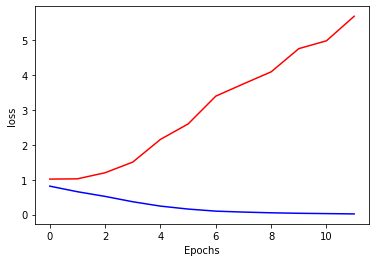

In [128]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

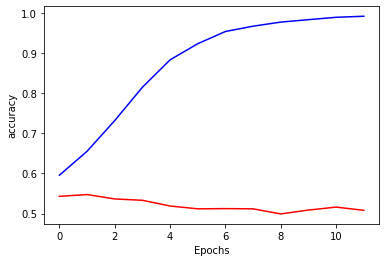

In [129]:
# Visualization of accuracy training 
plt.plot(history.history["sparse_categorical_accuracy"], color="b")
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

### Stap 4 : Conclusie

Becommentarieer je 3 gebruikte methodes en motiveer de keuzes die je gemaakt hebt. Maak een vergelijking tussen de methodes en geef aan waarom een methode volgens jou minder / beter presteert.